# Table Of Contents


1. [Library Import](#Library-Import)
2. [Data Loading](#Data-Loading)
3. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
   - [Datasets Description](#Datasets-Description)
   - [Missing Data Analysis](#Missing-Data-Analysis)
   - [Visuals](#Visuals)
4. [Feature Engineering](#Feature-Engineering)
   - [Prepare Data](#Prepare-Data)
   - [Creating Aggregate Features](#Creating-Aggregate-Features)
   - [Creating Rolling Features](#Creating-Rolling-Features)
   - [Encoding Categorical Variables](#Encoding-Categorical-Variables)
5. [Data Preprocessing](#Data-Preprocessing)
   - [Defines Features](#Defines-Features)
   - [Handling Missing Values](#Handling-Missing-Values)
6. [Model Training Evaluation](#Model-Training-Evaluation)
   - [Random Forest Regressor](#Random-Forest-Regressor)
   - [Gradient Boosting Regressor](#Gradient-Boosting-Regressor)
   - [LightGBM Regressor](#LightGBM-Regressor)
   - [Model Comparison](#Model-Comparison)
7. [Hyperparameter Tuning](#Hyperparameter-Tuning)

# Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb

# Data Loading


In [2]:
booknow_booking = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv')
booknow_theaters = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv')
booknow_visits = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv')
cinePOS_booking = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv')
cinePOS_theaters = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv')
date_info = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv')
data_relation = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv')
sample_submission = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')

# Exploratory Data Analysis (EDA)

In [3]:
print(booknow_booking.shape, booknow_theaters.shape, booknow_visits.shape, cinePOS_booking.shape, cinePOS_theaters.shape, date_info.shape, data_relation.shape, sample_submission.shape)

(68336, 4) (829, 5) (214046, 3) (1641966, 4) (4690, 5) (547, 2) (150, 2) (38062, 2)


In [4]:
sample_submission.head(10)

,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0
5,book_00001_2024-03-07,0
6,book_00001_2024-03-08,0
7,book_00001_2024-03-09,0
8,book_00001_2024-03-10,0
9,book_00001_2024-03-11,0


## Datasets Description

BookNow: An online booking and aggregation platform where users can search theatres and book tickets in advance.

CinePOS: a point-of-sale (POS) system installed at theaters that tracks on-site ticket sales.

* booknow_booking.csv – BookNow bookings
* booknow_theaters.csv – BookNow theatre info
* booknow_visits.csv – Daily audience counts
* cinePOS_theaters.csv – CinePOS theatre info
* cinePOS_booking.csv – CinePOS bookings
* date_info.csv – Calendar info
* movie_theater_id_relation.csv – Mapping between BookNow and CinePOS theatres.

In [5]:
for dfname, name in zip([booknow_booking, booknow_theaters, booknow_visits,cinePOS_booking, cinePOS_theaters, date_info, data_relation],
                    ['booknow_booking','booknow_theaters','booknow_visits',
                     'cinePOS_booking','cinePOS_theaters','date_info','relation']):
    print(f"\n{name}")
    print(dfname.head(3))


booknow_booking
  book_theater_id        show_datetime     booking_datetime  tickets_booked
0      book_00244  2023-01-01 19:00:00  2023-01-01 16:00:00               1
1      book_00740  2023-01-01 19:00:00  2023-01-01 19:00:00               3
2      book_00740  2023-01-01 19:00:00  2023-01-01 19:00:00               6

booknow_theaters
  book_theater_id theater_type theater_area   latitude  longitude
0      book_00093        Drama     Area_001  22.619233  78.113017
1      book_00078        Drama     Area_001  22.619233  78.113017
2      book_00291        Drama     Area_001  22.619233  78.113017

booknow_visits
  book_theater_id   show_date  audience_count
0      book_00001  2023-01-13              50
1      book_00001  2023-01-14              64
2      book_00001  2023-01-15              58

cinePOS_booking
  cine_theater_id        show_datetime     booking_datetime  tickets_sold
0   cinePOS_00001  2023-01-01 11:00:00  2023-01-01 09:00:00             1
1   cinePOS_00002  2023-01-01 13

In [6]:
booknow_visits.head()

,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


In [7]:
booknow_visits['show_date'].min()

'2023-01-01'

In [8]:
booknow_visits['show_date'].max()

'2024-02-28'

**Insights :**

* Date Range in booknow_visits dataset is from 01-01-2023 to 28-02-2024

In [9]:
print(cinePOS_theaters['cine_theater_id'].nunique())
print(data_relation['cine_theater_id'].nunique())

4690
150


**Insights :**

* BookNow = online booking platform are 829 theaters
* CinePOS = POS system at theaters are 4,690 theaters
* Only 150 theaters are linked between them


In [10]:
booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'])
date_info['show_date'] = pd.to_datetime(date_info['show_date'])
booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'])
booknow_booking['booking_datetime'] = pd.to_datetime(booknow_booking['booking_datetime'])

In [11]:
df = booknow_visits.merge(date_info, on='show_date', how='left')

In [12]:
date_info['show_date'].min()

Timestamp('2023-01-01 00:00:00')

In [13]:
date_info['show_date'].max()

Timestamp('2024-06-30 00:00:00')

In [14]:
len(date_info)

547

**Insights :**

* In Date info dataset : Range of the dates are from 01-01-2023 to 30-06-2024
* Total dates are 547

## Missing Data Analysis

In [15]:
for name, dfname in zip(['booknow_booking','booknow_theaters','booknow_visits','cinePOS_booking','cinePOS_theaters','date_info','data_relation'], [booknow_booking,booknow_theaters,booknow_visits,cinePOS_booking,cinePOS_theaters,date_info,data_relation]):
    print(f"{name}:")
    print(dfname.isna().sum())
    print()

booknow_booking:
book_theater_id     0
show_datetime       0
booking_datetime    0
tickets_booked      0
dtype: int64

booknow_theaters:
book_theater_id    515
theater_type         0
theater_area         0
latitude             0
longitude            0
dtype: int64

booknow_visits:
book_theater_id    0
show_date          0
audience_count     0
dtype: int64

cinePOS_booking:
cine_theater_id     0
show_datetime       0
booking_datetime    0
tickets_sold        0
dtype: int64

cinePOS_theaters:
cine_theater_id       0
theater_type          0
theater_area          0
latitude           3861
longitude          3861
dtype: int64

date_info:
show_date      0
day_of_week    0
dtype: int64

data_relation:
book_theater_id    0
cine_theater_id    0
dtype: int64



**Insights :**
**Key Insights on Missing Values in Datasets:**

1. Most of the datasets have complete data. Only two datasets have null values in 1-2 columns.
2. **booknow_theaters**: 515 theaters IDs entries are null. Without an ID, we cannot link these theaters. We will remove them to prevent merge errors.
3. **cinePOS_theaters**: Significant values of this dataset latitude(3861), longitude (3861) have null values.



In [16]:
# Handle missing theaters
booknow_theaters_clean = booknow_theaters.dropna(subset=['book_theater_id'])

## Visuals

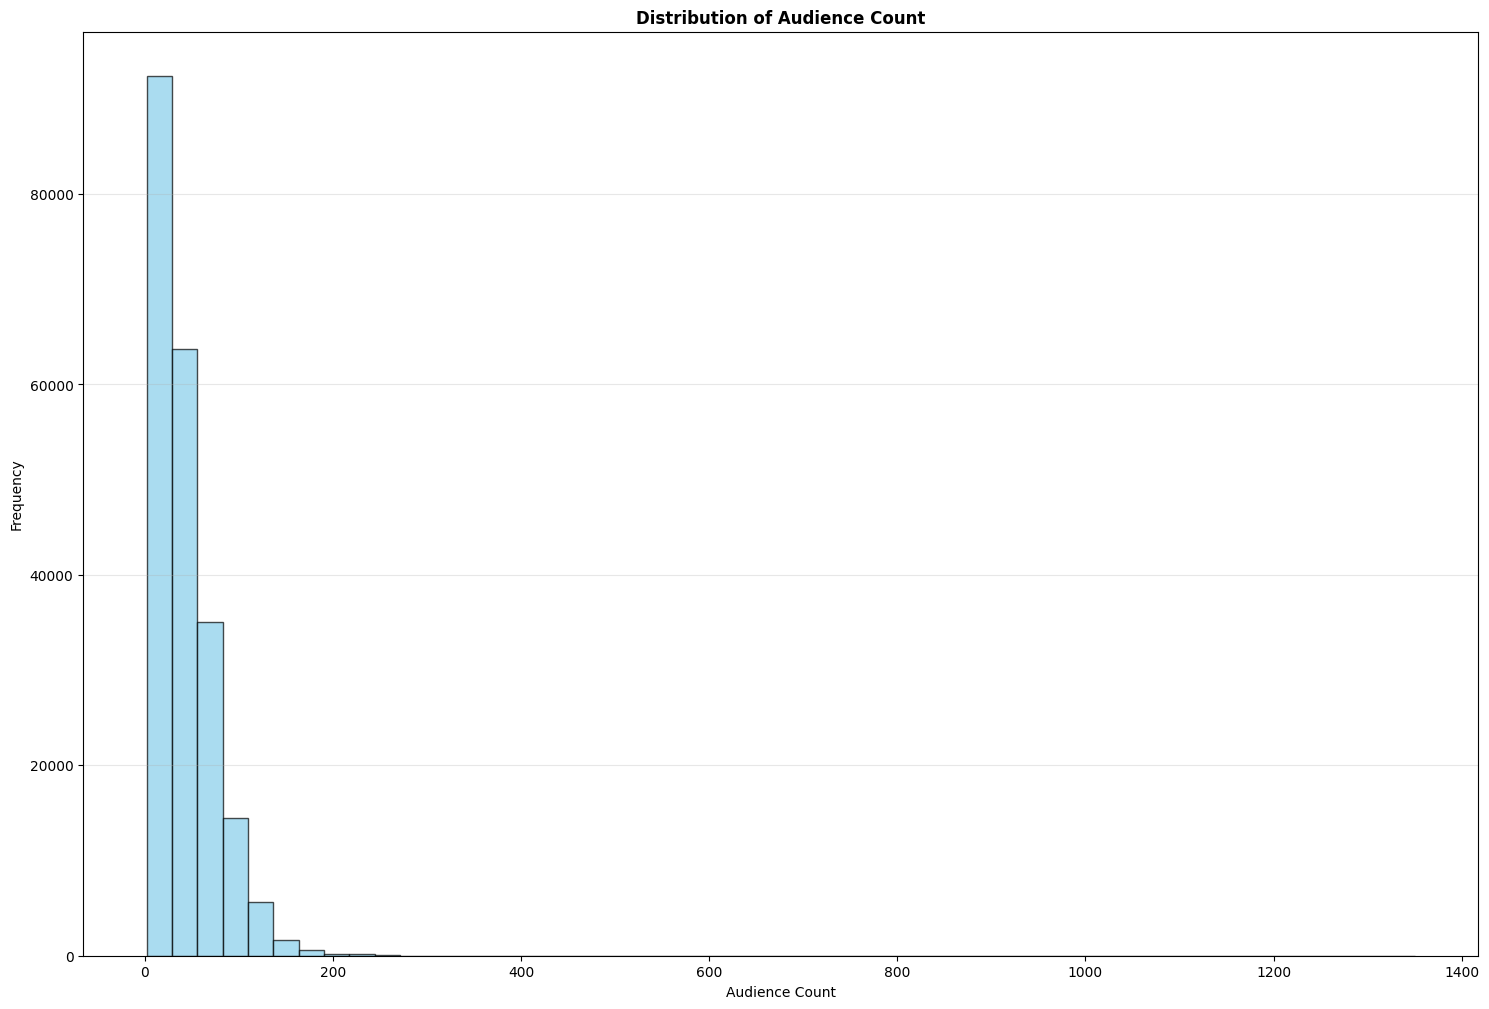

In [17]:
fig = plt.figure(figsize=(18, 12))

# Target Distribution
plt.hist(df['audience_count'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Distribution of Audience Count', fontsize=12, fontweight='bold')
plt.xlabel('Audience Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)

In [18]:
df['audience_count'].describe()

count    214046.000000
mean         41.616568
std          32.834918
min           2.000000
25%          18.000000
50%          34.000000
75%          58.000000
max        1350.000000
Name: audience_count, dtype: float64

**Insights :**
* Right-skewed distribution shows most days have moderate attendance with rare high-value outliers from special events.
* Peak frequency between 15-40 audience
* Median: 34 people in typical days
* Min : 2 not 0

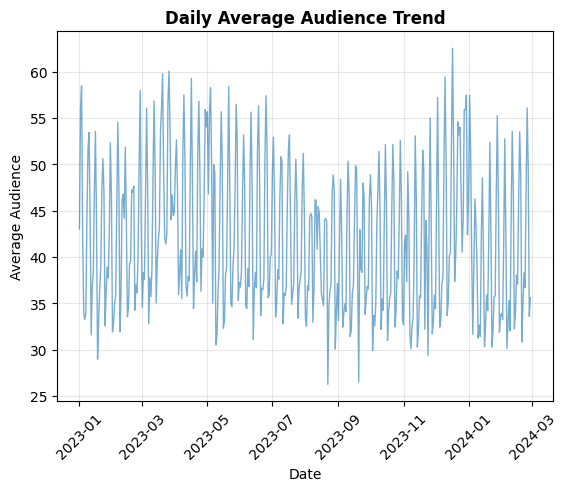

In [19]:
daily_avg = df.groupby('show_date')['audience_count'].mean()
plt.plot(daily_avg.index, daily_avg.values, alpha=0.6, linewidth=1)
plt.title('Daily Average Audience Trend', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Average Audience')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

**Insights :**
* High volatility ups and downs daily.
* December touched peak (holiday season, New Year)
* January 2024 dips
* This confirmed strong weekly seasonality - the same pattern repeats every 
7 days.

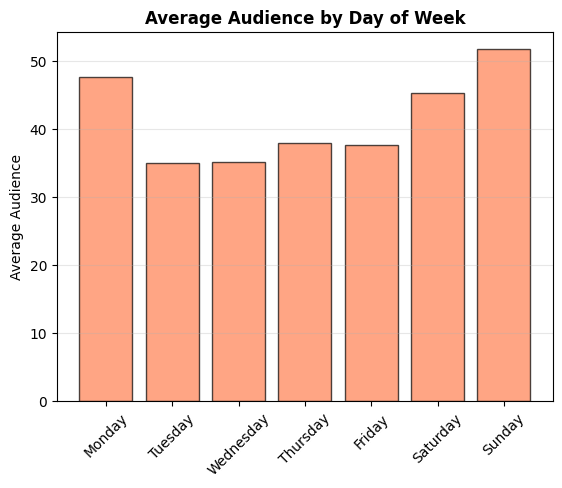

In [20]:
dow_avg = df.groupby('day_of_week')['audience_count'].mean()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.bar(dow_order, [dow_avg.get(day, 0) for day in dow_order], 
        color='coral', alpha=0.7, edgecolor='black')
plt.title('Average Audience by Day of Week', fontsize=12, fontweight='bold')
plt.ylabel('Average Audience')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

**Insights :**
* Sunday and Monday are busiest.
* The day-of-week pattern shows clear consumer behavior - weekends are busy as 
expected, but Monday being second-highest is interesting, possibly due to new 
release momentum or special promotions.

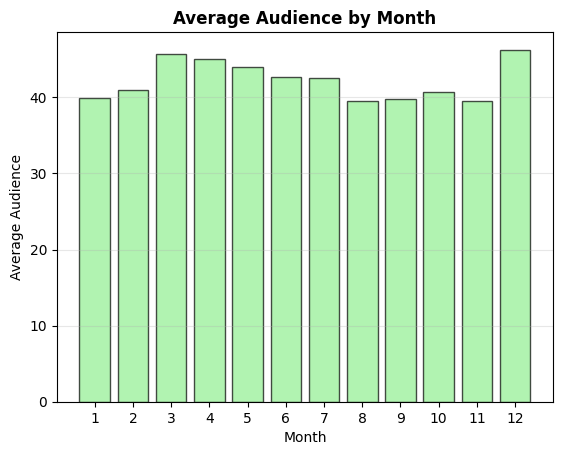

In [21]:
df['month'] = df['show_date'].dt.month
monthly_avg = df.groupby('month')['audience_count'].mean()
plt.bar(monthly_avg.index, monthly_avg.values, color='lightgreen', alpha=0.7, edgecolor='black')
plt.title('Average Audience by Month', fontsize=12, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Audience')
plt.xticks(range(1, 13))
plt.grid(axis='y', alpha=0.3)

**Insights :**
* March is peak season at 45 average
* Highest: December (~46), March (~45) - Holidays & festivals
* Lowest: Aug - Sept (~38-39) - Summer slowdown

([<matplotlib.axis.XTick at 0x7c569c32d8d0>,
 [Text(1, 0, 'Monday'),
  Text(2, 0, 'Tuesday'),
  Text(3, 0, 'Wednesday'),
  Text(4, 0, 'Thursday'),
  Text(5, 0, 'Friday'),
  Text(6, 0, 'Saturday'),
  Text(7, 0, 'Sunday')])

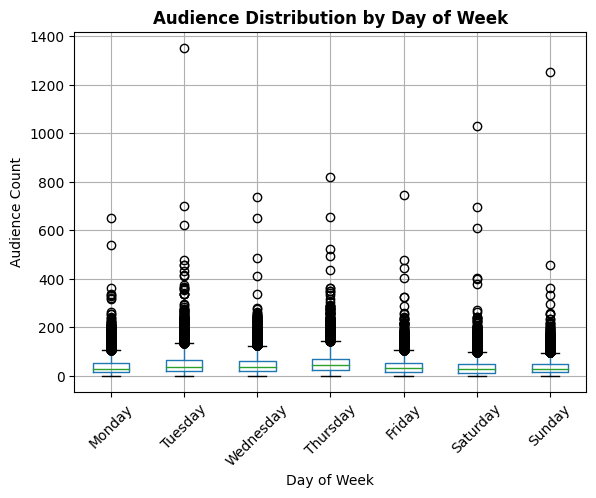

In [22]:
df.boxplot(column='audience_count', by='day_of_week', ax=plt.gca())
plt.title('Audience Distribution by Day of Week', fontsize=12, fontweight='bold')
plt.suptitle('') 
plt.xlabel('Day of Week')
plt.ylabel('Audience Count')
plt.xticks(range(1, 8), dow_order, rotation=45)

**Insights :**
* Box plots showing the full distribution (not just average) for each day.
* The box plots reveal that weekends aren't just busier, they're also LESS predictable.

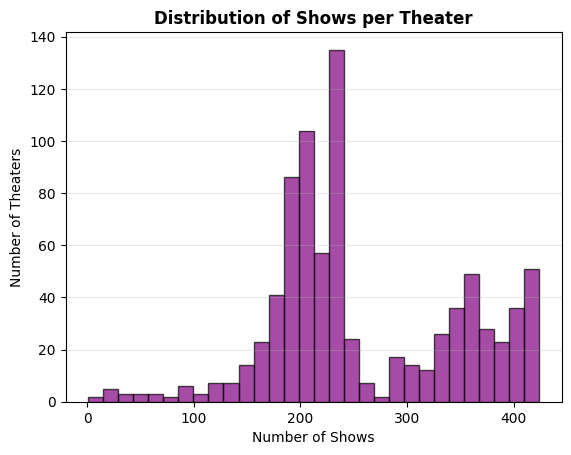

In [23]:
theater_counts = df['book_theater_id'].value_counts()
plt.hist(theater_counts.values, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.title('Distribution of Shows per Theater', fontsize=12, fontweight='bold')
plt.xlabel('Number of Shows')
plt.ylabel('Number of Theaters')
plt.grid(axis='y', alpha=0.3)

**Insights :**
* Most theaters: 200-300 shows
* Few theaters: 400+ shows (very active theaters)

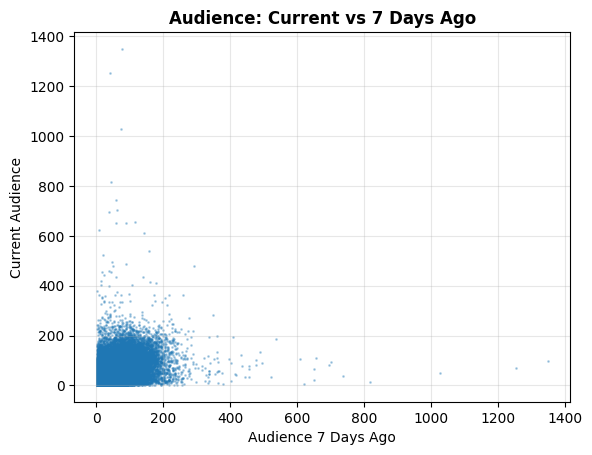

In [24]:
df_sorted = df.sort_values(['book_theater_id', 'show_date'])
df_sorted['lag_7'] = df_sorted.groupby('book_theater_id')['audience_count'].shift(7)
valid_lags = df_sorted[df_sorted['lag_7'].notna()]
plt.scatter(valid_lags['lag_7'], valid_lags['audience_count'], alpha=0.3, s=1)
plt.title('Audience: Current vs 7 Days Ago', fontsize=12, fontweight='bold')
plt.xlabel('Audience 7 Days Ago')
plt.ylabel('Current Audience')
plt.grid(alpha=0.3)

**Insights :**
* Clear positive correlation.
* It tells LAG_7 is a VERY important feature.
* If last Saturday had 50 people, this Saturday likely has ~45-55 people. 
The pattern is strong but not perfect.

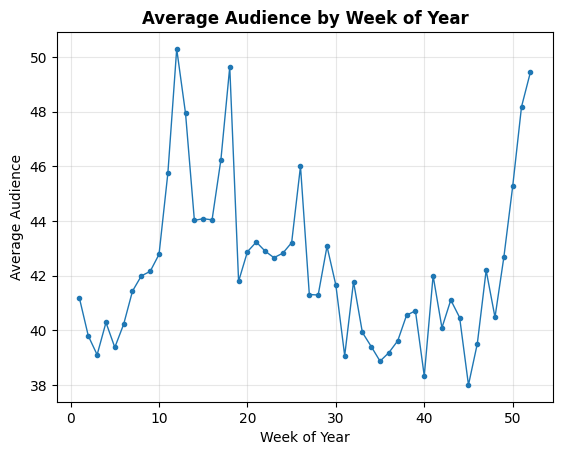

In [25]:
df['week'] = df['show_date'].dt.isocalendar().week
weekly_avg = df.groupby('week')['audience_count'].mean()
plt.plot(weekly_avg.index, weekly_avg.values, marker='o', markersize=3, linewidth=1)
plt.title('Average Audience by Week of Year', fontsize=12, fontweight='bold')
plt.xlabel('Week of Year')
plt.ylabel('Average Audience')
plt.grid(alpha=0.3)

**Insights :**
* Line plot showing average attendance across all 52 weeks of the year.
* Week 12-13 (March): PEAK ~50 average - THIS IS OUR TEST PERIOD.
* Week 51-52 (December): Year-end peak ~48-49

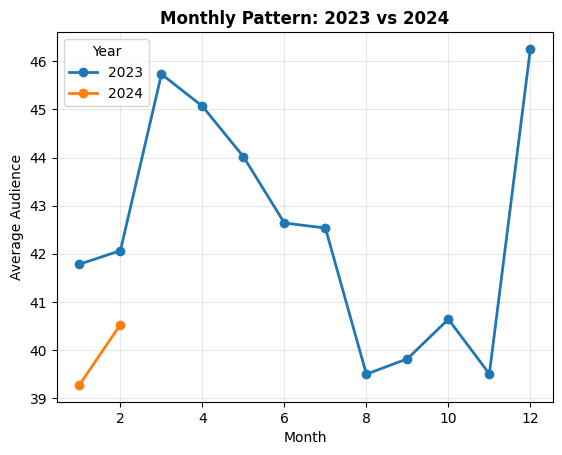

In [26]:
df['year'] = df['show_date'].dt.year
yearly_monthly = df.groupby(['year', 'month'])['audience_count'].mean().unstack()
yearly_monthly.T.plot(ax=plt.gca(), marker='o', linewidth=2)
plt.title('Monthly Pattern: 2023 vs 2024', fontsize=12, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Audience')
plt.legend(title='Year')
plt.grid(alpha=0.3)

**Insights :**
* Recent data more relevant than old data
* Attendance is down 5-7% this year compared to last year.
* Predictions need seasonal boost

# Feature Engineering

## Prepare Data

In [27]:
booknow_booking['show_date'] = booknow_booking['show_datetime'].dt.date
booknow_booking['show_date'] = pd.to_datetime(booknow_booking['show_date'])
bookings_agg = booknow_booking.groupby(['book_theater_id', 'show_date']).agg({
    'tickets_booked': 'sum',
    'booking_datetime': 'count'
}).reset_index()
bookings_agg.columns = ['book_theater_id', 'show_date', 'total_bookings', 'num_transactions']

In [28]:
test = sample_submission.copy()
test['book_theater_id'] = test['ID'].str.rsplit('_', n=1).str[0]
test['show_date'] = pd.to_datetime(test['ID'].str.rsplit('_', n=1).str[1])
test['audience_count'] = np.nan

# Combine train and test
df = pd.concat([
    booknow_visits[['book_theater_id', 'show_date', 'audience_count']],
    test[['book_theater_id', 'show_date', 'audience_count']]
], ignore_index=True)

df = df.sort_values(['book_theater_id', 'show_date']).reset_index(drop=True)

In [29]:
# Merge date info and theater info
df = df.merge(date_info, on='show_date', how='left')
df = df.merge(booknow_theaters_clean[['book_theater_id', 'theater_type', 'theater_area']], 
              on='book_theater_id', how='left')
df['theater_type'] = df['theater_type'].fillna('Unknown')
df['theater_area'] = df['theater_area'].fillna('Unknown')

In [30]:
# Merge CinePOS relation
df = df.merge(data_relation, on='book_theater_id', how='left')
df['has_cinepos_link'] = df['cine_theater_id'].notna().astype(int)
df = df.drop(columns=['cine_theater_id'])

In [31]:
# Merge bookings
df = df.merge(bookings_agg, on=['book_theater_id', 'show_date'], how='left')
df['total_bookings'] = df['total_bookings'].fillna(0)
df['num_transactions'] = df['num_transactions'].fillna(0)

In [32]:
# Date features
df['dow'] = df['show_date'].dt.dayofweek
df['day'] = df['show_date'].dt.day
df['month'] = df['show_date'].dt.month
df['year'] = df['show_date'].dt.year
df['is_weekend'] = (df['dow'] >= 5).astype(int)
df['week_of_year'] = df['show_date'].dt.isocalendar().week.astype(int)

## Creating Aggregate Features

In [33]:
train_subset = df[df['audience_count'].notna()].copy()

In [34]:
# Global averages
df['global_dow_avg'] = df['dow'].map(train_subset.groupby('dow')['audience_count'].mean())
df['global_week_avg'] = df['week_of_year'].map(train_subset.groupby('week_of_year')['audience_count'].mean())
df['global_month_avg'] = df['month'].map(train_subset.groupby('month')['audience_count'].mean())

In [35]:
# Theater and Area average
df['theater_avg'] = df['book_theater_id'].map(train_subset.groupby('book_theater_id')['audience_count'].mean())
df['area_avg'] = df['theater_area'].map(train_subset.groupby('theater_area')['audience_count'].mean())

## Creating Rolling Features

In [36]:
# Rolling averages
for n in [5, 10, 20]:
    df[f'recent_{n}'] = df.groupby('book_theater_id')['audience_count'].transform(
        lambda x: x.rolling(n, min_periods=1).mean().shift(1)
    )

In [37]:
# Lags
df['lag_7'] = df.groupby('book_theater_id')['audience_count'].shift(7)
df['lag_14'] = df.groupby('book_theater_id')['audience_count'].shift(14)

## Encoding Categorical Variables

In [38]:
# Label Encoding
le_theater = LabelEncoder()
le_area = LabelEncoder()
le_type = LabelEncoder()

df['theater_enc'] = le_theater.fit_transform(df['book_theater_id'])
df['area_enc'] = le_area.fit_transform(df['theater_area'])
df['type_enc'] = le_type.fit_transform(df['theater_type'])

# Data Preprocessing

In [39]:
# Split back into train and test
train_data = df[df['audience_count'].notna()].copy()
test_data = df[df['audience_count'].isna()].copy()

# Train-validation split: March 2023 as validation
val_mask = (train_data['year'] == 2023) & (train_data['month'] == 3)
val = train_data[val_mask].copy()
train = train_data[~val_mask].copy()

## Handling Missing Values

In [40]:
fill_cols = ['theater_avg', 'area_avg', 'global_dow_avg', 'global_week_avg', 
             'global_month_avg', 'recent_5', 'recent_10', 'recent_20', 'lag_7', 'lag_14']
overall_mean = train['audience_count'].mean()

for col in fill_cols:
    mean_val = train[col].mean() if train[col].notna().any() else overall_mean
    train[col] = train[col].fillna(mean_val)
    val[col] = val[col].fillna(mean_val)
    test_data[col] = test_data[col].fillna(mean_val)

## Define Features

In [41]:
features = [
    'area_enc', 'week_of_year', 'dow', 'month', 'has_cinepos_link', 'is_weekend',
    'total_bookings', 'num_transactions', 'global_week_avg', 'global_dow_avg', 
    'global_month_avg', 'area_avg', 'theater_avg', 'theater_enc', 'type_enc',
    'recent_5', 'recent_10', 'recent_20', 'lag_7', 'lag_14', 'day'
]

# Model Training and Evaluation

In [42]:
# Store results
results = []

## Random Forest Regressor

In [43]:
rf = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=20, 
                           random_state=42, n_jobs=-1)
rf.fit(train[features], train['audience_count'])

rf_val_pred = np.clip(rf.predict(val[features]), 0, None)
rf_val_r2 = r2_score(val['audience_count'], rf_val_pred)
rf_val_mae = mean_absolute_error(val['audience_count'], rf_val_pred)

In [44]:
rf_val_r2

0.5620237605317195

In [45]:
rf_val_mae

15.805040651922788

* Val R2 : 0.5620
* Val MAE : 15.81

In [46]:
results.append({'Model': 'Random Forest', 'Val_R2': rf_val_r2, 'Val_MAE': rf_val_mae})

## Gradient Boosting Regressor

In [47]:
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5,
                               min_samples_split=20, random_state=42)
gb.fit(train[features], train['audience_count'])

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_split=20,
                          n_estimators=200, random_state=42)

In [48]:
gb_val_pred = np.clip(gb.predict(val[features]), 0, None)
gb_val_r2 = r2_score(val['audience_count'], gb_val_pred)
gb_val_mae = mean_absolute_error(val['audience_count'], gb_val_pred)

In [49]:
gb_val_r2

0.5528001325106908

In [50]:
gb_val_mae

15.868692923165733

* Val R2 : 0.5528
* Val MAE : 15.87

In [51]:
results.append({'Model': 'Gradient Boosting', 'Val_R2': gb_val_r2, 'Val_MAE': gb_val_mae})

## LightGBM Regressor

In [52]:
lgbm_model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=30,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1
)

lgbm_model.fit(train[features], train['audience_count'])

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=8,
              min_child_samples=30, n_estimators=2000, random_state=42,
              reg_alpha=0.1, reg_lambda=0.1, subsample=0.8, verbose=-1)

In [53]:
lgbm_val_pred = np.clip(lgbm_model.predict(val[features]), 0, None)
lgbm_val_r2 = r2_score(val['audience_count'], lgbm_val_pred)
lgbm_val_mae = mean_absolute_error(val['audience_count'], lgbm_val_pred)

In [54]:
lgbm_val_r2

0.5673864134702185

In [55]:
lgbm_val_mae

15.619138707134445

* Val R2 : 0.5674
* Val MAE : 15.62

In [56]:
results.append({'Model': 'LightGBM', 'Val_R2': lgbm_val_r2, 'Val_MAE': lgbm_val_mae})

## Model Comparison

In [57]:
# Create comparison table
comparison_df = pd.DataFrame(results).sort_values('Val_R2', ascending=False)

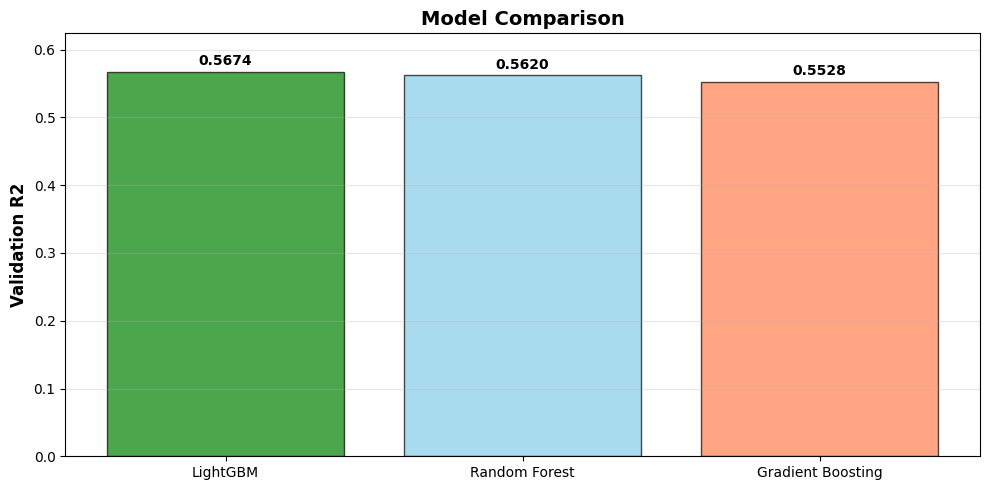

In [58]:
plt.figure(figsize=(10, 5))
plt.bar(comparison_df['Model'], comparison_df['Val_R2'], 
        color=['green', 'skyblue', 'coral'], edgecolor='black', alpha=0.7)
plt.ylabel('Validation R2', fontweight='bold', fontsize=12)
plt.title('Model Comparison', fontweight='bold', fontsize=14)
plt.ylim(0, max(comparison_df['Val_R2']) * 1.1)
plt.grid(axis='y', alpha=0.3)
for i, (model, r2) in enumerate(zip(comparison_df['Model'], comparison_df['Val_R2'])):
    plt.text(i, r2 + 0.01, f'{r2:.4f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [59]:
lgbm_val_r2

0.5673864134702185

* Best model is LightGBM (R2 = 0.5674)

# Hyperparameter Tuning

In [60]:
# Test different configurations
configs = [
    {'n_estimators': 2000, 'learning_rate': 0.01, 'num_leaves': 31, 'max_depth': 8},  # Current config
    {'n_estimators': 2500, 'learning_rate': 0.008, 'num_leaves': 31, 'max_depth': 7},
    {'n_estimators': 3000, 'learning_rate': 0.01, 'num_leaves': 40, 'max_depth': 8},
]

best_r2 = 0
best_config = None

for i, config in enumerate(configs, 1):
    print(f"Config {i}: {config}")
    
    model_test = lgb.LGBMRegressor(
        **config,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=30,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        verbose=-1
    )
    
    model_test.fit(train[features], train['audience_count'])
    val_pred_test = np.clip(model_test.predict(val[features]), 0, None)
    r2_test = r2_score(val['audience_count'], val_pred_test)
    
    print(f"Validation R2: {r2_test:.4f}\n")
    
    if r2_test > best_r2:
        best_r2 = r2_test
        best_config = config

Config 1: {'n_estimators': 2000, 'learning_rate': 0.01, 'num_leaves': 31, 'max_depth': 8}
Validation R2: 0.5674

Config 2: {'n_estimators': 2500, 'learning_rate': 0.008, 'num_leaves': 31, 'max_depth': 7}
Validation R2: 0.5654

Config 3: {'n_estimators': 3000, 'learning_rate': 0.01, 'num_leaves': 40, 'max_depth': 8}
Validation R2: 0.5674



In [61]:
final_model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=30,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1
)

final_model.fit(train[features], train['audience_count'])

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=8,
              min_child_samples=30, n_estimators=2000, random_state=42,
              reg_alpha=0.1, reg_lambda=0.1, subsample=0.8, verbose=-1)

In [62]:
test_preds = final_model.predict(test_data[features])
test_preds = np.clip(test_preds, 0, None)

In [63]:
# Apply day-specific March boost
test_data['month_pred'] = test_data['show_date'].dt.month
test_data['dow_pred'] = test_data['show_date'].dt.dayofweek

In [64]:
march_boost = {
    0: 1.123,  
    1: 1.259,    
    2: 1.173,  
    3: 1.109,  
    4: 1.189,  
    5: 1.147,  
    6: 1.061   
}

march_mask = test_data['month_pred'] == 3
for dow, boost in march_boost.items():
    mask = march_mask & (test_data['dow_pred'] == dow)
    test_preds[mask.values] *= boost

In [65]:
# April boost
april_mask = test_data['month_pred'] == 4
if april_mask.sum() > 0:
    test_preds[april_mask.values] *= 1.128

# Final rounding
test_preds = np.clip(test_preds, 0, None).round().astype(int)

In [66]:
submission = pd.DataFrame({
    'ID': sample_submission['ID'],
    'audience_count': test_preds
})

submission.to_csv('submission.csv', index=False)
print(submission.head(10))

                      ID  audience_count
0  book_00001_2024-03-01              45
1  book_00001_2024-03-02              59
2  book_00001_2024-03-03              58
3  book_00001_2024-03-04              68
4  book_00001_2024-03-06              41
5  book_00001_2024-03-07              36
6  book_00001_2024-03-08              39
7  book_00001_2024-03-09              60
8  book_00001_2024-03-10              63
9  book_00001_2024-03-11              55


### end

In [67]:
# march_2023 = train_data[(train_data['year'] == 2023) & (train_data['month'] == 3)]
# march_avg_by_dow = march_2023.groupby('dow')['audience_count'].mean()
# march_avg_by_dow